# Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

**Инструкция по выполнению проекта**

1. Загрузите данные и выполните их ресемплирование по одному часу.
2. Проанализируйте данные.
3. Обучите разные модели с различными гиперпараметрами. Сделайте тестовую выборку размером 10% от исходных данных.
4. Проверьте данные на тестовой выборке и сделайте выводы.

**Описание данных**

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце '*num_orders*' (от англ. *number of orders*, «число заказов»).

## Подготовка

In [2]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import ParameterGrid
import lightgbm as lgb

Загрузим и ищучим данные

In [3]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
data.sort_index(inplace=True)

Произведем ресемплирование данных по часовому интервалу

In [4]:
data = data.resample('1H').sum()
data.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
2018-03-01 05:00:00,6
2018-03-01 06:00:00,12
2018-03-01 07:00:00,15
2018-03-01 08:00:00,34


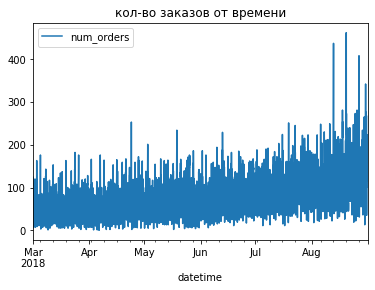

In [5]:
data.plot()
plt.title(label = 'кол-во заказов от времени')
plt.show()

In [6]:
print(data.index.max())
print(data.index.min())

2018-08-31 23:00:00
2018-03-01 00:00:00


## Анализ данных

Используем скользящее среднее для оценки данных

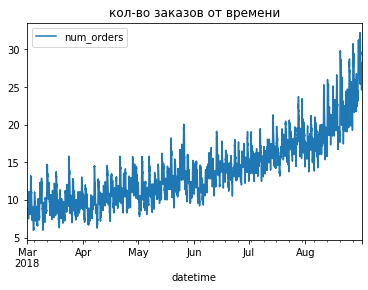

In [74]:
rolling_mean_value = data.rolling(100).mean()
rolling_mean_value.plot()
plt.title(label = 'кол-во заказов от времени')
plt.show()

###  Поиск трендов и сезонности

Изучим данные на наличие трендов и сезонности при помощи функции seasonal_decompose модуля statsmodels.tsa.seasonal

In [8]:
decomposed = seasonal_decompose(data)

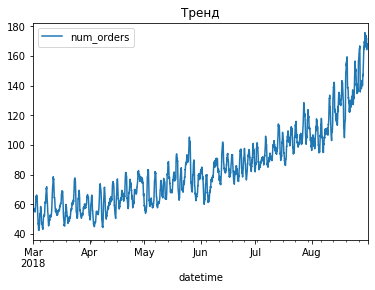

In [9]:
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.show()

#### Комментарий
Кол-во заказов в среднем растет со временем.

Теперь исследуем суточную и дневную сезонность

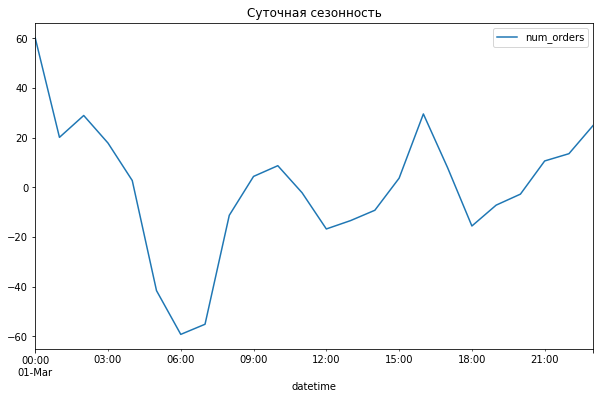

In [39]:
plt.figure(figsize=(10, 6))
plt.title('Суточная сезонность')
decomposed.seasonal['2018-03-01':'2018-03-01'].plot(ax=plt.gca())
plt.show()

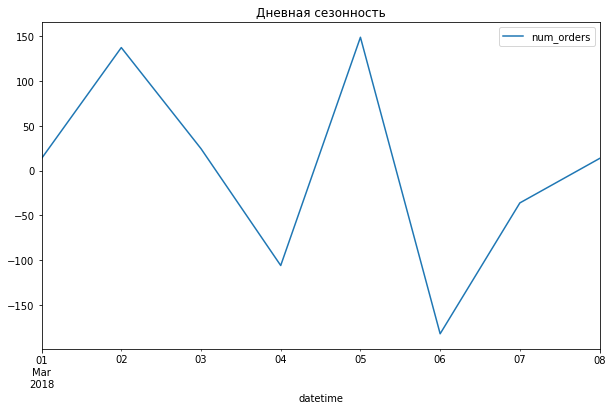

In [57]:
decomposed_by_day = seasonal_decompose(data.resample('D').sum())
plt.figure(figsize=(10, 6))
plt.title('Дневная сезонность')
decomposed_by_day.seasonal['2018-03-01':'2018-03-08'].plot(ax=plt.gca())
plt.show()

#### Комментарий
Графики, демонстрирующие сезонность по часам в течение суток и по дням в течение недели.

Осталось рассмотреть шумы

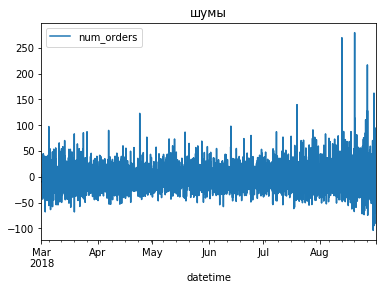

In [249]:
decomposed.resid.plot(ax=plt.gca())
plt.title('шумы')
plt.show()

#### Комментарий
Колебания шумов проходят вблизи нуля, хотя и присутсвуют некоторые выбросы.

### Вывод

Были построены графики разбиения на тренд, сезонность и остатки. 
Сезонность была выделена суточная и дневная. Эти графики показывают, что кол-во заказов различные в разлчиные дни недели и часы суток, поэтому день недели и часы суток будут использоваться, как признаки для построения моделей.

Вопрос с чем связан средний рост кол-ва заказов со временем сезонностью или трендом точно ответить нельзя. Горизонт предсказания составляет 10% от исходной выборки или ~3 недели. Все же я решил выделить месяц, как признак для предсказания моделей.

## Обучение

###  Создание признаков

Выберем признаки, которые будут использоваться для обучения моделей в соответствии с результами анализа в предыдущей части проекта.

In [8]:
def make_features(data, max_lag, rolling_mean_size):
    data['month'] = data.index.month
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [9]:
make_features(data, 10, 4)

#### Комментарий
make_features - функция, которая отвечает за создание признаков для обучения моделей.
В качестве признаков были выбраны месяц, день недели и час.
Остающие значения - 10. и скользящее среднее с окной шириной 4.
Почему в качестве выбора признаков для построения модели были выбраны время, день недели и месяц было описано выше. Что касается остальных признаков: остающих значений и скользящего среднего, то я не нашел какого-то универсального подхода для выбора параметров для этих значений, поэтому здесь приходилось полагаться на собственные догадки + проверки качества моделей для разных значений этих параметров. В процессе построения моделей я использовал разные аругменты для функции make_features были выбраны те, которые обеспечивают приемлимый результат + не самое долгое время на обучение моделей. 

### Разбиение на выборки

In [10]:
train_and_valid, test = train_test_split(data, shuffle=False, test_size=0.1)
print(train_and_valid.shape)
train_and_valid = train_and_valid.dropna()
print(train_and_valid.shape)

(3974, 15)
(3964, 15)


In [11]:
train, valid = train_test_split(train_and_valid, shuffle=False, test_size=0.2)

In [12]:
test.head(5)

,num_orders,month,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,rolling_mean
datetime,,,,,,,,,,,,,,,
2018-08-13 14:00:00,102,8,0,14,119.0,92.0,144.0,156.0,137.0,91.0,39.0,66.0,83.0,143.0,127.75
2018-08-13 15:00:00,175,8,0,15,102.0,119.0,92.0,144.0,156.0,137.0,91.0,39.0,66.0,83.0,114.25
2018-08-13 16:00:00,144,8,0,16,175.0,102.0,119.0,92.0,144.0,156.0,137.0,91.0,39.0,66.0,122.00
2018-08-13 17:00:00,152,8,0,17,144.0,175.0,102.0,119.0,92.0,144.0,156.0,137.0,91.0,39.0,135.00
2018-08-13 18:00:00,104,8,0,18,152.0,144.0,175.0,102.0,119.0,92.0,144.0,156.0,137.0,91.0,143.25


In [13]:
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']

features_valid = valid.drop(['num_orders'], axis=1)
target_valid = valid['num_orders']

features_train_and_valid = train_and_valid.drop(['num_orders'], axis=1)
target_train_and_valid = train_and_valid['num_orders']

features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

### Линейная регрессия

В качестве первой модели была выбрана - линейная регрессия.

In [14]:
model = LinearRegression()
model.fit(features_train, target_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [15]:
print("RMSE обучающей выборки: ", mean_squared_error(model.predict(features_train), target_train) ** 0.5)
print("RMSE валидационной выборки: ", mean_squared_error(model.predict(features_valid), target_valid) ** 0.5)

RMSE обучающей выборки:  27.977495778225986
RMSE валидационной выборки:  39.114096739694155


###  Случайный Лес

В данном случае я не использовал решетчатый поиск с перекрестной проверкой GridSearchCV из sklearn, т.к.важно не перемешивать объекты временного ряда, чтобы модель не обучалась на данных  из "будущего". Поэтому для настройки параметров модели использовалась собственная функция, осуществляющая перебор заданных гиперпараметров.

In [16]:
%%time
forrest_rmse = []
for estim in range(80,121, 10):
    for k in range(6,16,2):
        for m in range(2,10,2):
            forrest_model = RandomForestRegressor(random_state=12345, n_estimators = estim, max_depth = k, max_features = m)
            forrest_model.fit(features_train, target_train)
            cur_train_rmse = mean_squared_error(forrest_model.predict(features_train), target_train) ** 0.5
            cur_valid_rmse = mean_squared_error(forrest_model.predict(features_valid), target_valid) ** 0.5
            forrest_rmse.append([estim,k,m,cur_train_rmse,cur_valid_rmse])
data_forrest_rmse = pd.DataFrame(forrest_rmse, columns = ['n_estimators','max_depth','max_features','train_rmse','valid_rmse'])
display(data_forrest_rmse.sort_values(by='valid_rmse', ascending = True).head(20))

,n_estimators,max_depth,max_features,train_rmse,valid_rmse
58,100,14,6,9.663361,32.615529
98,120,14,6,9.615026,32.619391
78,110,14,6,9.653756,32.691609
38,90,14,6,9.690009,32.711040
99,120,14,8,9.508637,32.791304
18,80,14,6,9.713873,32.924541
79,110,14,8,9.537927,32.927335
59,100,14,8,9.553827,32.946980
39,90,14,8,9.584891,32.973932
19,80,14,8,9.591112,32.984995


CPU times: user 1min 24s, sys: 358 ms, total: 1min 25s
Wall time: 1min 25s


###  Градиентный бустинг деревьев с помощью Light gbm

Используем градиентный бустинг

In [223]:
%%time
gbdt_rmse = []
for estim in range(100,200, 10):
    for k in range(4,18,2):
        gbdt_model = lgb.LGBMRegressor(random_state=12345, n_estimators = estim, max_depth = k)
        gbdt_model.fit(features_train, target_train)
        cur_train_rmse = mean_squared_error(gbdt_model.predict(features_train), target_train) ** 0.5
        cur_valid_rmse = mean_squared_error(gbdt_model.predict(features_valid), target_valid) ** 0.5
        gbdt_rmse.append([estim,k,cur_train_rmse,cur_valid_rmse])
data_gbdt_rmse = pd.DataFrame(gbdt_rmse, columns = ['n_estimators','max_depth','train_rmse','valid_rmse'])
display(data_gbdt_rmse.sort_values(by='valid_rmse', ascending = True).head(20))

,n_estimators,max_depth,train_rmse,valid_rmse
1,100,6,13.733281,30.535483
8,110,6,13.397472,30.592722
15,120,6,13.015905,30.596248
9,110,8,12.255880,30.616175
2,100,8,12.762720,30.641112
22,130,6,12.835263,30.642206
23,130,8,11.602997,30.653664
29,140,6,12.642157,30.657924
16,120,8,11.889036,30.669212
43,160,6,12.051687,30.672997


CPU times: user 1min 45s, sys: 1.41 s, total: 1min 46s
Wall time: 1min 47s


## Тестирование


Перед тестированием модели, модели переобучались на суммарной обучающей и валидационной выборке при найденных оптимальных гиперпараметрах. 

In [252]:
result_rmse = []

In [253]:
model = LinearRegression()
model.fit(features_train_and_valid,target_train_and_valid)
result_rmse.append(['Линейная регрессия',mean_squared_error(model.predict(features_train_and_valid), target_train_and_valid) ** 0.5,mean_squared_error(model.predict(features_test), target_test) ** 0.5])

In [254]:
best_forrest_model = RandomForestRegressor(random_state=12345, n_estimators = 100, max_depth = 14, max_features = 6)
best_forrest_model.fit(features_train_and_valid, target_train_and_valid)
result_rmse.append(['Случайный лес',mean_squared_error(best_forrest_model.predict(features_train_and_valid), target_train_and_valid) ** 0.5,mean_squared_error(best_forrest_model.predict(features_test), target_test) ** 0.5])

In [255]:
best_gbdt_model = lgb.LGBMRegressor(random_state = 12345, boosting_type = 'gbdt', n_estimators = 100, max_depth = 6)
best_gbdt_model.fit(features_train_and_valid, target_train_and_valid)
result_rmse.append(['Град.бустинг деревьев',mean_squared_error(best_gbdt_model.predict(features_train_and_valid), target_train_and_valid) ** 0.5,mean_squared_error(best_gbdt_model.predict(features_test), target_test) ** 0.5])

In [259]:


display(pd.DataFrame(result_rmse, columns = ['Модель','RMSE_train','RMSE_test']).sort_values(by='RMSE_test', ascending = True))

,Модель,RMSE_train,RMSE_test
2,Град.бустинг деревьев,16.015008,43.553911
1,Случайный лес,10.868956,46.636110
0,Линейная регрессия,30.385367,54.154128


## Вывод


В результате выполнения работы были обработан и проанализирован временной ряд зависимости кол-ва заказов такси. Были созданы признаки, по которым были построены модели для предсказания кол-ва заказов. Модель случайного леса и модель град.бустинга показали результат RMSE < 48, но по качетсву прогноза град.бустинг показал более точный результат.